In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from pathlib import Path
import PIL
from PIL import Image
from torchvision import transforms
import pandas as pd
import cv2
from tqdm.notebook import tqdm
import torchmetrics
import seaborn as sns

In [13]:
root_path = Path('Data')

In [2]:
train_path = Path('Data/train/COVID19/')
size_list = []
size_list = [np.asarray(Image.open(i)).shape for i in list(train_path.glob('*'))]
df = pd.DataFrame(size_list)
df.describe()

,0,1,2
count,460.000000,460.000000,336.000000
mean,1309.558696,1439.773913,3.107143
std,710.897474,805.120157,0.309756
min,224.000000,224.000000,3.000000
25%,744.500000,886.500000,3.000000
50%,1024.000000,1050.500000,3.000000
75%,1971.000000,2000.000000,3.000000
max,4757.000000,5623.000000,4.000000


In [5]:
def load(path):
    img = Image.open(path)
    img = PIL.ImageOps.grayscale(img) 
    img = cv2.resize(np.asarray(img), (224,224)).astype(np.float32)/255
    return img

In [6]:
size_list = [load(i).shape for i in list(train_path.glob('*'))]
df = pd.DataFrame(size_list)
df.describe()

,0,1
count,460.0,460.0
mean,224.0,224.0
std,0.0,0.0
min,224.0,224.0
25%,224.0,224.0
50%,224.0,224.0
75%,224.0,224.0
max,224.0,224.0


In [10]:
def mean_std(root_path):
    sums, sum_squared = 0,0
    files = 0
    for path in tqdm(list(root_path.glob('*'))):
        for p in tqdm(list(path.glob('*'))):
            img = load(p)
            sums+= np.sum(img)/(img.shape[0]*img.shape[1])
            sum_squared+= np.sum(img**2)/(img.shape[0]*img.shape[1])
            files+=1
    print(files)
    mean = sums/files
    std = np.sqrt((sum_squared/files) - (mean**2))
    return mean, std
mean, std = mean_std(Path('Data/train'))
print(mean, std)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/460 [00:00<?, ?it/s]

  0%|          | 0/1266 [00:00<?, ?it/s]

  0%|          | 0/3418 [00:00<?, ?it/s]

5144
0.4920391255128484 0.23256543325130302


In [14]:
mean, std = 0.4920391255128484, 0.23256543325130302

50176
50176


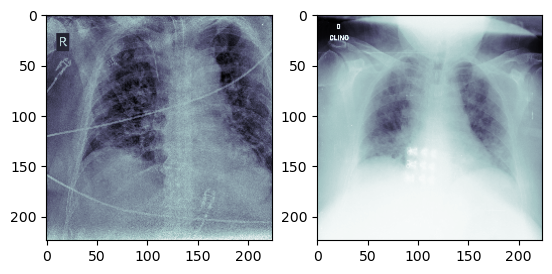

In [7]:
fig, ax = plt.subplots(1,2)
n = 0
for i in list(train_path.glob('*')):
    im = load(i)
    print(im.shape[0]*im.shape[1])
    ax[n].imshow(im, cmap = 'bone')
    n+=1
    if n==2:
        break

In [15]:
class LungDataset(torch.utils.data.Dataset):
    def __init__(self, rootpath= None, train_transforms= None, val_transforms= None,num_train= None,seed_val= 42):
        super().__init__()
        self.train_transforms = train_transforms
        self.val_transforms = val_transforms
        self.num_train = num_train
        self.filenames = self.extractandshuffle(rootpath, seed_val)
            
    def extractandshuffle(self, path, seed_val):
        files = []
        for paths in list(path.glob('*')):
            # print(paths)
            for classes in list(paths.glob('*')):
                # print(classes)
                for f in list(classes.glob('*')):
                    # print(f)
                    files.append((f, classes))
        np.random.seed(seed_val)
        np.random.shuffle(files)
        if self.train_transforms!=None:
            files = files[:self.num_train]
        else:
            files = files[self.num_train:]
        return files
        
    @staticmethod
    def get_label(path):
        labels =['COVID19', 'NORMAL', 'PNEUMONIA']
        return labels.index(list(path.parts)[-1])
        
    def load(self, path, transforms):
        img = Image.open(path)
        img = PIL.ImageOps.grayscale(img) 
        img = cv2.resize(np.asarray(img), (224,224)).astype(np.float32)/255
        img = transforms(img)
        return img

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        file_id = self.filenames[index][0]
        label = self.filenames[index][1]
        if self.train_transforms !=None:  
            return self.load(file_id, self.train_transforms), self.get_label(label)
        else:
            return self.load(file_id, self.val_transforms), self.get_label(label)
                

In [16]:
train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = mean, std =std), transforms.RandomAffine(degrees = (-5,5),
    translate=(0, 0.05),
    scale=(0.9, 1.1)), transforms.RandomRotation(10),transforms.RandomResizedCrop((224,224), #(0.9,1.1),
    scale=(0.35, 1)),
    transforms.RandomHorizontalFlip(p =0.3),
    transforms.ElasticTransform()])
val_transform =  transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = mean, std =std)])

train_data = LungDataset(root_path, train_transform, None, 5144, 42)
val_data = LungDataset(root_path, None, val_transform, 5144, 42)

In [314]:
classes = np.array([i[1] for i in train_data])
weights = np.unique(classes, return_counts=True)[1]
weights = len(classes)/weights
print(np.unique(classes, return_counts=True))
print(weights)
class_weights =[]
for _, label in tqdm(train_data):
    if label == 0:
        class_weights.append(weights[0])
    elif label == 1:
        class_weights.append(weights[1])
    elif label == 2:
        class_weights.append(weights[2])
    else:
        print('Unknown class')

  0%|          | 0/5144 [00:00<?, ?it/s]

In [17]:
# np.save('class_weights_shuffled', class_weights)
class_weights =np.load('class_weights_shuffled.npy')
np.unique(class_weights)[-1::-1]

array([10.69438669,  4.07606973,  1.51249632])

In [7]:
# cw = np.load('class_weights_shuffled.npy')
# cw[cw ==10.69438669]=14
# cw[cw ==4.07606973]=5
# np.unique(cw, return_counts=True)

In [18]:
sampler = torch.utils.data.WeightedRandomSampler(weights = class_weights, num_samples=len(train_data))
train_loader = torch.utils.data.DataLoader(dataset = train_data, sampler = sampler, batch_size=10)
val_loader = torch.utils.data.DataLoader(dataset = val_data, shuffle = False, batch_size=10)

In [9]:
len(train_loader), len(val_loader)

(515, 129)

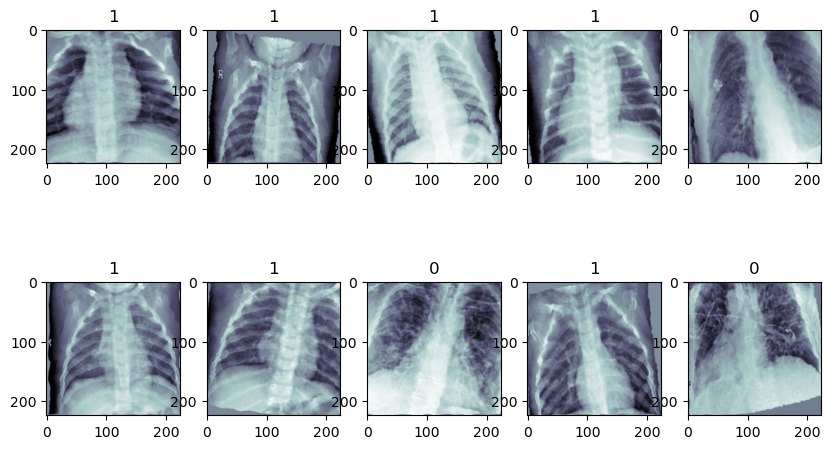

In [10]:
for b, (X,y) in enumerate(train_loader):
    fig, ax = plt.subplots(2,5, figsize =(10,6))
    k=0
    for i in range(2):
        for j in range(5):
            ax[i][j].imshow(np.transpose(X[k].numpy(), (1,2,0)), cmap = 'bone')
            ax[i][j].set_title(y[k].item())
            k+=1

    break


In [5]:
from torchvision.models import resnet18

In [12]:
model = resnet18(pretrained=True)
model

D:\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# for layer in list(model.parameters())[1:-1]:
#     layer.requires_grad = False

In [8]:
class ResNet(torch.nn.Module):
    def __init__(self,in_channels, out_features, layers =None):
        super().__init__()
        torch.manual_seed(4)
        self.model = resnet18(pretrained=True)
        self.model.conv1 = torch.nn.Conv2d(in_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=out_features, bias=True)
        self.num_parameters = len(list(self.model.named_parameters()))

        if layers:
            for l in range(self.num_parameters):
                name,param =  list(self.model.named_parameters())[l]
                param.requires_grad = False
            
            for l in layers:           
                name,param =  list(self.model.named_parameters())[l]
                param.requires_grad = True
                print(f'Setting {name} grad to True') #To print the layers with gradients turned off
        
        # for name,param in list(self.model.named_parameters())[1:-5]:
        #     print(f'Setting {name} grad to False') #To print the layers with gradients turned off
        #     param.requires_grad = False
    def forward(self, X):
        pred = self.model(X)
        return pred
        # return torch.nn.functional.softmax(pred, dim = 1)

In [63]:
# for i, (name, p) in enumerate(list(new_model.named_parameters())):
#     print(i,name)

In [11]:
#Check to make sure the gradients are set accordingly
for name,p in new_model.named_parameters():
    print(p.requires_grad)

True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True


In [27]:

# num_layers = len(list(new_model.parameters()))
new_model = ResNet(1,3, [0,-6,-5,-4,-3,-2,-1])
new_model;
device = ['cuda:0' if torch.cuda.is_available() == True else 'cpu']

def optimizer_model_parameters(model, *layers):
    param = []
    for i in layers:
        param.append(list(model.parameters())[i])
    return param
    
epochs = 50
model_parameters = optimizer_model_parameters(new_model, 0,-6,-5,-4,-3,-2,-1)
optimizer = torch.optim.SGD(model_parameters,lr=0.1, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10,gamma = 0.1)
train_losses=[]
val_losses = []
Train_Accuracy= []
Val_Accuracy = []
Train_Loss_Epoch = []

new_model = new_model.to(device[0])

# print(len(train_parameters_layers))
# print(len(model_parameters))
# print(train_parameters_layers)
# print('***************************************************************************')
# print(model_parameters)


Setting conv1.weight grad to True
Setting layer4.1.bn1.bias grad to True
Setting layer4.1.conv2.weight grad to True
Setting layer4.1.bn2.weight grad to True
Setting layer4.1.bn2.bias grad to True
Setting fc.weight grad to True
Setting fc.bias grad to True


In [28]:
for e in tqdm(range(epochs)):
    
    train_batch_corr = 0
    print('**************************Training Results*********************************')
    for b, (X_train, y_train) in tqdm(enumerate(train_loader), total = len(train_loader)):
        
        pred = new_model(X_train.float().to(device[0]))
        loss= criterion(pred.cpu(), y_train)
        train_batch_corr+= torch.sum(torch.argmax(pred.cpu(), dim=1)==y_train).item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if b % 200 ==0:
            print(f'Epoch,batch: {e,b} Loss:{loss.item()} Accuracy: {train_batch_corr/((b+1)*len(y_train))}')
          
    lr_scheduler.step()
    Train_Accuracy.append(train_batch_corr/((b+1)* len(train_loader)))
    train_losses.append(loss.item())
    
    print('**************************Validation Results*********************************')
    with torch.no_grad():        
        val_batch_corr = 0
        val_loss = 0
        
        for b_t, (X_test, y_test) in tqdm(enumerate(val_loader), total = len(val_loader)):
            
            val_pred = new_model(X_test.float().to(device[0]))
            vloss= criterion(val_pred.cpu(), y_test)
            # val_loss+=loss.item()
            val_batch_corr+= torch.sum(torch.argmax(val_pred.cpu(), dim=1)==y_test).item()
            if b_t % 50 ==0:
                
                print(f'Epoch,batch: {e,b_t} Loss:{vloss.item()} Accuracy: {val_batch_corr/((b_t+1)*len(y_test))}')
    val_losses.append(vloss.item())           
    Val_Accuracy.append(val_batch_corr/((b+1)*len(val_loader)))
    # plt.plot(range(e+1), Train_Accuracy)
    # plt.plot(range(e+1), Val_Accuracy)
    # plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

**************************Training Results*********************************


  0%|          | 0/515 [00:00<?, ?it/s]

D:\anaconda3\Lib\site-packages\torch\autograd\graph.py:768: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch,batch: (0, 0) Loss:1.2409963607788086 Accuracy: 0.5


KeyboardInterrupt: 

In [ ]:
# plt.plot(range(epochs), Val_Accuracy)
torch.save(new_model.state_dict(), 'Shuffled_model_6_layers_lr0,1gamma0,1_step10')
metrics_dict = {'Train_accuracy': Train_Accuracy, 'Val Accuracy': Val_Accuracy, 'Train_Loss': train_losses, 'Val_Loss':val_losses}
with open('Shuffled_model_6_layers_lr0,1gamma0,1_step10_Metrics.txt', 'w') as f:
    f.write(str(metrics_dict))

In [ ]:
# import subprocess
# subprocess.run(["shutdown", "-s"])

ValueError: x and y must have same first dimension, but have shapes (50,) and (0,)

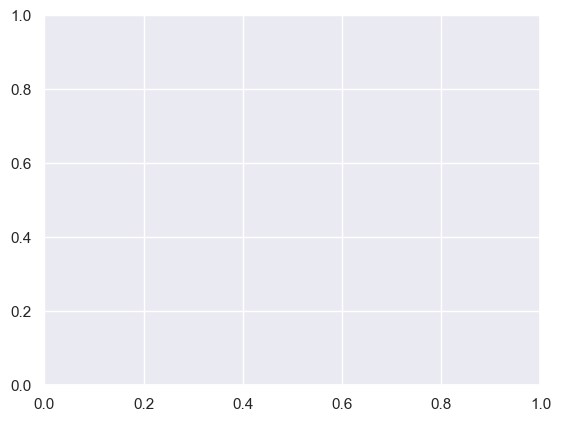

In [76]:
plt.plot(range(epochs), train_losses)
plt.plot(range(epochs), val_losses)
# plt.legend()

In [72]:
# test_loader = torch.utils.data.DataLoader(dataset = val_data, shuffle = False, batch_size=10)
# new_model = ResNet(1,3)
# new_model.load_state_dict(torch.load('Shuffled_model_5_layers'))
# new_model.to(device[0])
# new_model.eval()
# with torch.no_grad():
#     preds = []
#     labels = []
#     for b,(X,y) in tqdm(enumerate(val_loader)):
#         pred = new_model(X.to(device[0]))
#         loss =criterion(pred.cpu(), torch.tensor(y))
#         preds.append(pred)
#         labels.append(y)

C:\Users\sesha\AppData\Local\Temp\ipykernel_15788\3411794599.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load('Shuffled_model_5_layer

0it [00:00, ?it/s]

C:\Users\sesha\AppData\Local\Temp\ipykernel_15788\3411794599.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss =criterion(pred.cpu(), torch.tensor(y))


0.7496124031007751
967 1290
Acc:0.8582649827003479
Precision: 0.6718870997428894
Recall: 0.8582649827003479
F1_score: 0.6987230777740479


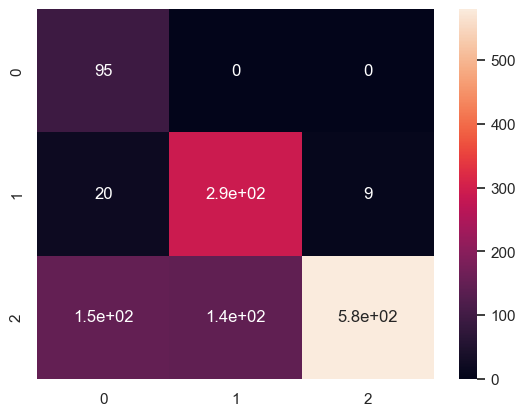

In [111]:
# pred = [torch.argmax(i, axis =1).cpu() for i in preds]
# corr = 0
# for i in range(len(pred)):
#     # print((pred[i].cpu() == labels[i]).numpy())
#     corr+= np.sum((pred[i].cpu() == labels[i]).numpy())
# print(corr/(len(pred)*10))
# print(corr,len(labels)*10)
# preds_1d = []
# labels_1d =[]
# for i in pred:
#     for j in i:
#         preds_1d.append(j)
                
# for i in labels:
#     for j in i:
#         labels_1d.append(j)
# cf_mat = torchmetrics.ConfusionMatrix(task= 'multiclass', num_classes =3)
# Acc = torchmetrics.Accuracy(task= 'multiclass', num_classes =3,average="macro")
# Recall = torchmetrics.Recall(task= 'multiclass', num_classes =3,average="macro")
# F1 = torchmetrics.F1Score(task= 'multiclass', num_classes =3,average="macro")
# Precision = torchmetrics.Precision(task= 'multiclass', num_classes =3,average="macro")


# acc_score = Acc(torch.tensor((preds_1d)), torch.tensor(labels_1d))
# f1_score = F1(torch.tensor((preds_1d)), torch.tensor(labels_1d))
# precision_score =Precision(torch.tensor((preds_1d)), torch.tensor(labels_1d))
# recall_score = Recall(torch.tensor((preds_1d)), torch.tensor(labels_1d))
# cf=cf_mat(torch.tensor((preds_1d)), torch.tensor(labels_1d))
# sns.heatmap(cf, annot = True)
# print(f'Acc:{acc_score}\nPrecision: {precision_score}\nRecall: {recall_score}\nF1_score: {f1_score}')

In [29]:
def results(model, data_loader,*model_state_dicts):

    sns.set()
    fig, ax = plt.subplots(len(model_state_dicts),1, figsize = (10,20))
    models_results = dict.fromkeys(model_state_dicts)
    device= ['cuda:0' if torch.cuda.is_available() == True else 'cpu']
    
    for index, state_dict in tqdm(enumerate(model_state_dicts), total=len(model_state_dicts)):
        
        model.load_state_dict(torch.load(state_dict))
        model.to(device[0])
        model.eval()
        
        with torch.no_grad():
            preds = []
            labels = []
            for b,(X,y) in tqdm(enumerate(data_loader), total = len(data_loader)):
                pred = model(X.to(device[0]))
                loss =criterion(pred.cpu(), torch.tensor(y))
                preds.append(pred)
                labels.append(y)
        pred = [torch.argmax(i, axis =1).cpu() for i in preds]
        corr = 0
        for i in range(len(pred)):
            # print((pred[i].cpu() == labels[i]).numpy())
            corr+= np.sum((pred[i].cpu() == labels[i]).numpy())
        # print(corr/(len(pred)*10))
        # print(corr,len(labels)*10)
        preds_1d = []
        labels_1d =[]
        for i in pred:
            for j in i:
                preds_1d.append(j)
                        
        for i in labels:
            for j in i:
                labels_1d.append(j)
        cf_mat = torchmetrics.ConfusionMatrix(task= 'multiclass', num_classes =3)
        Acc = torchmetrics.Accuracy(task= 'multiclass', num_classes =3,average="macro",)
        Recall = torchmetrics.Recall(task= 'multiclass', num_classes =3,average="macro")
        F1 = torchmetrics.F1Score(task= 'multiclass', num_classes =3,average="macro")
        Precision = torchmetrics.Precision(task= 'multiclass', num_classes =3,average="macro")
        
        
        acc_score = Acc(torch.tensor((preds_1d)), torch.tensor(labels_1d))
        f1_score = F1(torch.tensor((preds_1d)), torch.tensor(labels_1d))
        precision_score =Precision(torch.tensor((preds_1d)), torch.tensor(labels_1d))
        recall_score = Recall(torch.tensor((preds_1d)), torch.tensor(labels_1d))
        cf=cf_mat(torch.tensor((preds_1d)), torch.tensor(labels_1d))
        sns.heatmap(cf, annot = True, ax= ax[index])
        state_dict = Path(state_dict).parts[-1]
        ax[index].set_title(state_dict)
        ax[index].set_xlabel('Prediction')
        ax[index].set_ylabel('Label')
        # print(f'Acc:{acc_score}\nPrecision: {precision_score}\nRecall: {recall_score}\nF1_score: {f1_score}')
        models_results[state_dict] = {'Accuracy':acc_score, 'Precision':precision_score, 'Recall':recall_score, 'F1 Score': f1_score, 'Confusion_Matrix':cf}
    return models_results

  0%|          | 0/9 [00:00<?, ?it/s]

C:\Users\sesha\AppData\Local\Temp\ipykernel_12052\3085216216.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(state_dict))


  0%|          | 0/129 [00:00<?, ?it/s]

C:\Users\sesha\AppData\Local\Temp\ipykernel_12052\3085216216.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss =criterion(pred.cpu(), torch.tensor(y))
C:\Users\sesha\AppData\Local\Temp\ipykernel_12052\3085216216.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user 

  0%|          | 0/129 [00:00<?, ?it/s]

C:\Users\sesha\AppData\Local\Temp\ipykernel_12052\3085216216.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss =criterion(pred.cpu(), torch.tensor(y))
C:\Users\sesha\AppData\Local\Temp\ipykernel_12052\3085216216.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user 

  0%|          | 0/129 [00:00<?, ?it/s]

C:\Users\sesha\AppData\Local\Temp\ipykernel_12052\3085216216.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss =criterion(pred.cpu(), torch.tensor(y))
C:\Users\sesha\AppData\Local\Temp\ipykernel_12052\3085216216.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user 

  0%|          | 0/129 [00:00<?, ?it/s]

C:\Users\sesha\AppData\Local\Temp\ipykernel_12052\3085216216.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss =criterion(pred.cpu(), torch.tensor(y))
C:\Users\sesha\AppData\Local\Temp\ipykernel_12052\3085216216.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user 

  0%|          | 0/129 [00:00<?, ?it/s]

C:\Users\sesha\AppData\Local\Temp\ipykernel_12052\3085216216.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss =criterion(pred.cpu(), torch.tensor(y))
C:\Users\sesha\AppData\Local\Temp\ipykernel_12052\3085216216.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user 

  0%|          | 0/129 [00:00<?, ?it/s]

C:\Users\sesha\AppData\Local\Temp\ipykernel_12052\3085216216.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss =criterion(pred.cpu(), torch.tensor(y))
C:\Users\sesha\AppData\Local\Temp\ipykernel_12052\3085216216.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user 

  0%|          | 0/129 [00:00<?, ?it/s]

C:\Users\sesha\AppData\Local\Temp\ipykernel_12052\3085216216.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss =criterion(pred.cpu(), torch.tensor(y))
C:\Users\sesha\AppData\Local\Temp\ipykernel_12052\3085216216.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user 

  0%|          | 0/129 [00:00<?, ?it/s]

C:\Users\sesha\AppData\Local\Temp\ipykernel_12052\3085216216.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss =criterion(pred.cpu(), torch.tensor(y))
C:\Users\sesha\AppData\Local\Temp\ipykernel_12052\3085216216.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user 

  0%|          | 0/129 [00:00<?, ?it/s]

C:\Users\sesha\AppData\Local\Temp\ipykernel_12052\3085216216.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss =criterion(pred.cpu(), torch.tensor(y))


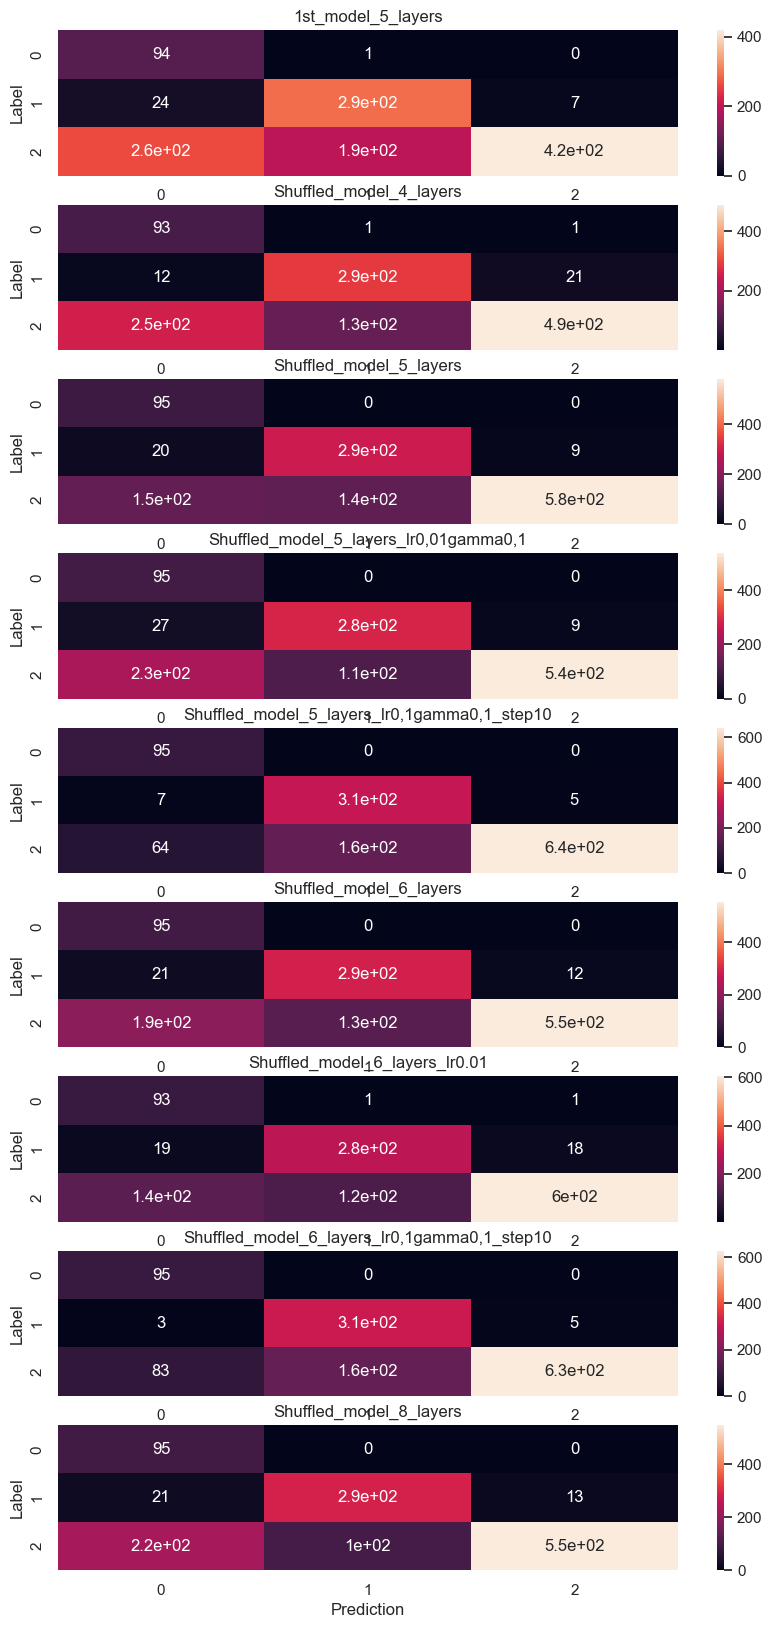

In [39]:
from pathlib import Path
model = ResNet(1,3,)
res = results(new_model, val_loader,'1st_model_5_layers', 'Shuffled_model_4_layers','Shuffled_model_5_layers','Shuffled_model_5_layers_lr0,01gamma0,1','Shuffled_model_5_layers_lr0,1gamma0,1_step10','Shuffled_model_6_layers','Shuffled_model_6_layers_lr0.01','Shuffled_model_6_layers_lr0,1gamma0,1_step10', 'Shuffled_model_8_layers')

In [40]:
res

{'1st_model_5_layers': {'Accuracy': tensor(0.7908),
  'Precision': tensor(0.6100),
  'Recall': tensor(0.7908),
  'F1 Score': tensor(0.5872),
  'Confusion_Matrix': tensor([[ 94,   1,   0],
          [ 24, 290,   7],
          [260, 194, 418]])},
 'Shuffled_model_4_layers': {'Accuracy': tensor(0.8123),
  'Precision': tensor(0.6347),
  'Recall': tensor(0.8123),
  'F1 Score': tensor(0.6320),
  'Confusion_Matrix': tensor([[ 93,   1,   1],
          [ 12, 288,  21],
          [253, 130, 489]])},
 'Shuffled_model_5_layers': {'Accuracy': tensor(0.8583),
  'Precision': tensor(0.6719),
  'Recall': tensor(0.8583),
  'F1 Score': tensor(0.6987),
  'Confusion_Matrix': tensor([[ 95,   0,   0],
          [ 20, 292,   9],
          [148, 144, 580]])},
 'Shuffled_model_5_layers_lr0,01gamma0,1': {'Accuracy': tensor(0.8338),
  'Precision': tensor(0.6591),
  'Recall': tensor(0.8338),
  'F1 Score': tensor(0.6599),
  'Confusion_Matrix': tensor([[ 95,   0,   0],
          [ 27, 285,   9],
          [227, 110,

In [41]:
df = pd.DataFrame(res)

In [42]:
df

,1st_model_5_layers,Shuffled_model_4_layers,Shuffled_model_5_layers,"Shuffled_model_5_layers_lr0,01gamma0,1","Shuffled_model_5_layers_lr0,1gamma0,1_step10",Shuffled_model_6_layers,Shuffled_model_6_layers_lr0.01,"Shuffled_model_6_layers_lr0,1gamma0,1_step10",Shuffled_model_8_layers
Accuracy,tensor(0.7908),tensor(0.8123),tensor(0.8583),tensor(0.8338),tensor(0.9000),tensor(0.8434),tensor(0.8525),tensor(0.8980),tensor(0.8405)
Precision,tensor(0.6100),tensor(0.6347),tensor(0.6719),tensor(0.6591),tensor(0.7388),tensor(0.6598),tensor(0.6763),tensor(0.7253),tensor(0.6657)
Recall,tensor(0.7908),tensor(0.8123),tensor(0.8583),tensor(0.8338),tensor(0.9000),tensor(0.8434),tensor(0.8525),tensor(0.8980),tensor(0.8405)
F1 Score,tensor(0.5872),tensor(0.6320),tensor(0.6987),tensor(0.6599),tensor(0.7838),tensor(0.6739),tensor(0.7060),tensor(0.7695),tensor(0.6702)
Confusion_Matrix,"[[tensor(94), tensor(1), tensor(0)], [tensor(2...","[[tensor(93), tensor(1), tensor(1)], [tensor(1...","[[tensor(95), tensor(0), tensor(0)], [tensor(2...","[[tensor(95), tensor(0), tensor(0)], [tensor(2...","[[tensor(95), tensor(0), tensor(0)], [tensor(7...","[[tensor(95), tensor(0), tensor(0)], [tensor(2...","[[tensor(93), tensor(1), tensor(1)], [tensor(1...","[[tensor(95), tensor(0), tensor(0)], [tensor(3...","[[tensor(95), tensor(0), tensor(0)], [tensor(2..."


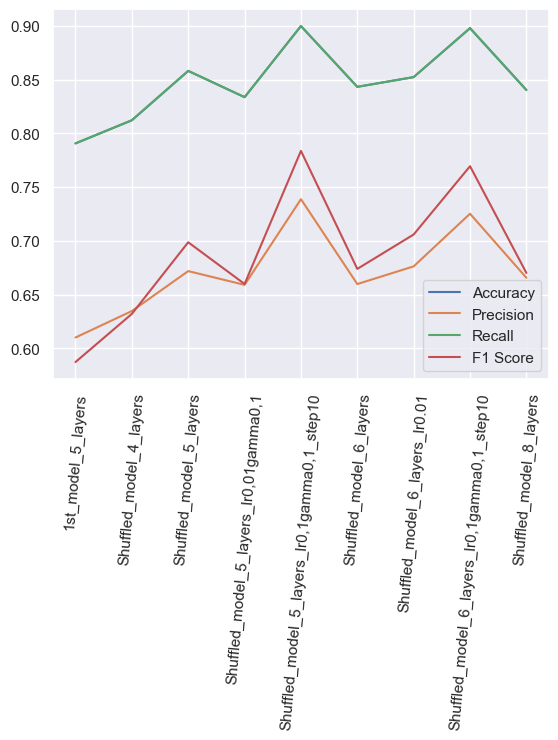

In [43]:
# fig, ax = plt.subplots(2,2, figsize = (15,15))
fig = plt.figure()
rows = df.index
row_index = 0
for i in range(2):
    for j in range(2):
        # ax[i][j].plot(df.columns,df.loc[rows[row_index]])
        # ax[i][j].tick_params(axis='x', labelrotation = 20)
        # ax[i][j].set_title(rows[row_index])
        # row_index+=1
        plt.plot(df.columns,df.loc[rows[row_index]])
        plt.xticks(rotation=85)
        row_index+=1
plt.legend(df.index)        
plt.show()
fig.tight_layout()
